In [1]:
import os, math, random, string, itertools
from math import sqrt

# for average per row
import numpy as np
import pandas as pd

In [2]:
# NLTK Import
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.util import ngrams
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
# for plotting
from scipy import spatial
from scipy.linalg import svd
from scipy.sparse.linalg import svds

# import spacy
# from spacy import displacy

# for metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib
from matplotlib import pyplot as plt

# for logging
import logging

logging.basicConfig(
	format='%(asctime)s %(levelname)-8s %(message)s',
	level=logging.INFO,
	datefmt='%Y-%m-%d %H:%M:%S')

logger = logging

<div style="text-align: left;">
    <h3>&nbsp;&nbsp;&nbsp;&nbsp;Get All Data Path</h3>
</div>

In [4]:
# get all data path
base_input = "data/"
base_output = "out/"
my_process_objects = []

files = []

def getAllInputData(input_data_path):
    """
    Get all input data from the input_data_path
    """
    
    for subdir in os.listdir(input_data_path):
        new_path = input_data_path + subdir
        if new_path.endswith(".txt"):
            files.append(new_path)
        elif os.path.isdir(new_path):
            getAllInputData(new_path + "/")

    return files


getAllInputData(base_input)

['data/C1/article01.txt',
 'data/C1/article02.txt',
 'data/C1/article03.txt',
 'data/C1/article04.txt',
 'data/C1/article05.txt',
 'data/C1/article06.txt',
 'data/C1/article07.txt',
 'data/C1/article08.txt',
 'data/C4/article01.txt',
 'data/C4/article02.txt',
 'data/C4/article03.txt',
 'data/C4/article04.txt',
 'data/C4/article05.txt',
 'data/C4/article06.txt',
 'data/C4/article07.txt',
 'data/C4/article08.txt',
 'data/C7/article01.txt',
 'data/C7/article02.txt',
 'data/C7/article03.txt',
 'data/C7/article04.txt',
 'data/C7/article05.txt',
 'data/C7/article06.txt',
 'data/C7/article07.txt',
 'data/C7/article08.txt']

<div style="text-align: left;">
    <h3>&nbsp;&nbsp;&nbsp;&nbsp;Preprocessing</h3>
</div>

In [5]:
print(word_tokenize("Imaa a students. "), "\n" ,set(string.punctuation))

['Imaa', 'a', 'students', '.'] 
 {',', ')', ']', '&', ':', '~', '*', '$', '@', '.', '!', '+', '/', ';', '}', '`', '"', '<', '%', '\\', '>', '{', '#', '-', '(', "'", '[', '_', '|', '?', '=', '^'}


In [6]:
# Proprocessing
class Preprocessor():

    # easy way to increment an index of the class instance
    # https://stackoverflow.com/questions/1045344/how-do-you-create-an-incremental-id-in-a-python-class
    index = itertools.count()

    def __init__(self, file):
        self.file_basename = file
        self.filename = "./" + file
        self.out_filename = "./" + base_output + file
        self.lines = []
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.document = []
        self.document_text = ""
        self.keywords_concepts = []
        self.ngrams = []
        self.ngrams_frequency = {}
        self.index = next(Preprocessor.index)

    def read_file(self):
        # read the file into an array of lines
        logger.info("opening file %s ...", self.filename)

        with open(self.filename) as f:
            self.lines = f.readlines()

            logger.debug("line 0: %s", self.lines[0])

    def filter_stopwords_lemmatize(self):
        logger.info("removing stopwords ...")
        new_lines = []

        for line in self.lines:
            if line is not None:

                # split and tokenize
                old_sentence = word_tokenize(line)

                for word in old_sentence:

                    # remove punctuation
                    # https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
                    exclude = set(string.punctuation)
                    word = ''.join(ch for ch in word if ch not in exclude)

                    # if its not empty
                    if word is not None and len(word) > 0:

                        # remove stopwords
                        if word not in self.stop_words:

                            # lemmatize
                            # best guess here to treat anything ending in 's'
                            # as a noun, anything else gets verb treatment
                            new_word = word
                            if word.endswith('s'):
                                new_word = self.lemmatizer.lemmatize(word)
                            else:
                                new_word = self.lemmatizer.lemmatize(word, "v")

                            # not entirely sure if i should be lowercasing everything
                            # new_word = new_word.lower()

                            # and add it to the text document
                            self.document.append(new_word)
                            # logger.info("%s => %s" % (word,new_word))

        self.document_text = ' '.join(self.document)

    def _find_bi_grams(self, text):

        bigrams = zip(text, text[1:])
        for gram in bigrams:

            bigram_string = ' '.join(gram)
            self.ngrams.append(bigram_string)

    def _find_tri_grams(self, text):
        # this doesnt seem to be producing as meaningful result as the bigram :/

        trigrams = zip(text, text[1:], text[2:])
        for gram in trigrams:

            trigram_string = ' '.join(gram)
            self.ngrams.append(trigram_string)

    def sliding_window_merge(self):
        logger.info("using a sliding window to merge remaining phrases ...")

        # ****************************************************
        # BI-GRAMS VS TRI-GRAMS ::
        #
        # 	I won't use trigrams bc frequencies arent as good
        # but logic for it is here in this block
        #
        #
        # self.ngrams = []
        #
        # self._find_tri_grams(self.document)
        #
        # for ngram in self.ngrams:
        # 	frequency = self.document_text.count(ngram)
        #
        # 	self.ngrams_frequency['ngram'] = frequency
        # 	print("%s : %s "% (ngram, frequency))
        #
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

        logger.info("using bi-grams for this, there are more matches...")
        # ngram_dist = nltk.FreqDist(nltk.bigrams(self.document))
        # print(ngram_dist.most_common())

        # i will pick everything with freq > 1 for the merge

        self._find_bi_grams(self.document)
        # print(self.ngrams)

        # dedupe the ngrams
        self.ngrams = list(dict.fromkeys(self.ngrams))

        for ngram in self.ngrams:
            frequency = self.document_text.count(ngram)

            self.ngrams_frequency[ngram] = frequency
            # print("%s : %s "% (ngram, frequency))

            # if frequency > 1, merge
            if frequency > 1:
                new_ngram = ngram.replace(" ", "_")

                # save the NGRAM for later matrix
                self.keywords_concepts.append(new_ngram)

                # then also replace the original text document
                self.document_text = self.document_text.replace(
                    ngram, new_ngram)

                print("\t\t %s : %s " % (ngram, frequency))

    def cleanup(self):

        for i in range(len(self.keywords_concepts)):
            self.keywords_concepts[i] = self.keywords_concepts[i].replace(
                "_", " ").lower()
            # print(self.keywords_concepts[i])

        self.ngrams_frequency = {k.replace("_", " ").lower(
        ): v for k, v in self.ngrams_frequency.items()}
        # print(self.ngrams_frequency.items())

        self.document_text = self.document_text.replace("_", " ").lower()
        # print(self.document_text)

    def write_output(self):

        logger.info("Writing output file " + self.out_filename)

        # WRITE THIS FILE WITHOUT ANY UNDERSCORES

        subDir = "/".join(self.out_filename.split("/")[:-1])

        if not os.path.exists(subDir):
            os.makedirs(subDir)

        with open(self.out_filename, "w") as outfile:
            for word in self.document_text:

                outfile.write(word.lower())


In [7]:
def write_keywords_concepts_file(P):

    logger.info("Appending to concepts file ...")
    concepts_file = "./" + base_output + "concepts.txt"

    with open(concepts_file, "a") as f:

        lines = P.keywords_concepts
        for line in lines:
            # print(line)
            f.write(line)
            f.write("\n")


def do_preprocessing():

    # for file in files[0:6]:
    for file in files:

        P = Preprocessor(file)

        # and add that object to the processed objects list

        # read the file
        P.read_file()

        # 2 - remove stopwords, lemmatize, and tokenize
        # https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
        P.filter_stopwords_lemmatize()

        # 3 - apply NER
        # https://www.analyticsvidhya.com/blog/2021/06/nlp-application-named-entity-recognition-ner-in-python-with-spacy/#:~:text=Named%20Entity%20Recognition%20is%20the,%2C%20money%2C%20time%2C%20etc.
        # P.apply_ner()

        # 4 - use sliding window approach to merge remaining phrases
        P.sliding_window_merge()

        # clean up my findings:
        # 	removes underscores from document text, lowercases
        # removes underscores from frequency keys, lowercases
        P.cleanup()

        # 5 - at the end, write to out_file for each document for safety
        P.write_output()

        my_process_objects.append(P)

        # also write the keywords concepts file
        write_keywords_concepts_file(P)

    return my_process_objects

In [ ]:
processed_objects = do_preprocessing()
my_process_objects[0].document_text

<div style="text-align: left;">
    <h3>&nbsp;&nbsp;&nbsp;&nbsp;Get TF-IDF Matrix</h3>
</div>

In [17]:
# for Document Term Matrix(TF-IDF)

# # collect keywords and terms across all the files
# def generate_term_document_matrix():
class TFIDFMatrix():

    def __init__(self):
        self.keywords_concepts = []

        self.matrix = []
        self.tf_idf_matrix = []

        self.cp_matrix = []
        self.TFIDF_matrix = []

        self.total_documents = len(my_process_objects)
        self.docs_with_keyword = {}

    def consolidate_keywords_concepts(self):
        # read the file into an array of lines
        logger.info("Collecting all of the keywords concepts ...")
        for file_object in my_process_objects:

            for keyword in file_object.keywords_concepts:
                if keyword not in self.keywords_concepts:

                    self.keywords_concepts.append(keyword.lower())

    def initialize_matrix(self):
        logger.info("initializing the zero matrix ...")

        # fill with 0s for the correct size matrix
        num_rows = len(my_process_objects)
        num_cols = len(self.keywords_concepts)

        # https://intellipaat.com/community/63426/how-to-create-a-zero-matrix-without-using-numpy
        self.matrix = [([0]*num_cols) for i in range(num_rows)]

    def fill_matrix(self):

        logger.info("Creating the document term matrix ...")
        i = 0
        for i in range(len(my_process_objects)):

            file_object = my_process_objects[i]

            # convert all the keys to lowercase for now
            the_files_ngrams = {
                k.lower(): v for k, v in file_object.ngrams_frequency.items()}
            print(file_object.ngrams_frequency)

            # iterate over the keywords_concepts list
            for j in range(len(self.keywords_concepts)):

                # if a keyword_concept is in the document_text of the document
                # count the number of times the substring appears
                if self.keywords_concepts[j] in file_object.document_text:

                    # https://stackoverflow.com/questions/8899905/count-number-of-occurrences-of-a-substring-in-a-string
                    frequency = file_object.document_text.count(
                        self.keywords_concepts[j])
                    self.matrix[i][j] = frequency

                # else:
                # 	print("%s not in document text" % self.keywords_concepts[j])
                # 	print(file_object.document_text)
        
        self.cp_matrix = self.matrix

    def _get_tf(self, document_object, row_index, col_index):
        # logger.debug("getting TF for a keyword in %s" % document_object.filename)

        # number of times the term occurs in the current document
        keywd_occurrence_this_document = self.matrix[row_index][col_index]

        # word count of the current document
        this_document_wordcount = len(document_object.document_text)

        if this_document_wordcount == 0:
            return 0.0  # Return 0 if the document is empty

        # logger.info("number of words in %s : %d" % (document_object.filename, this_document_wordcount))

        # make the tf calculation
        tf = float(keywd_occurrence_this_document / this_document_wordcount)

        return tf

    def _get_idf(self, keyword, row_index, col_index):
        # logger.info("getting IDF on keyword %s ... " % keyword)
        # math.log uses base e
        # test1 = math.log(20)
        # print(test1)

        num_documents_this_keyword = self.docs_with_keyword[keyword]
        idf = float(math.log(self.total_documents /
                    num_documents_this_keyword))

        return idf

    def _get_num_documents_containing_keyword(self):

        for col_index in range(len(self.keywords_concepts)):

            keyword = self.keywords_concepts[col_index]
            counter = 0

            # for each row of the current column
            for row_index in range(len(my_process_objects)):

                # is the value in the matrix > 0 ?
                if self.matrix[row_index][col_index] > 0:
                    counter += 1

            # logger.info("current keyword: %s num_documents %s" % (keyword, counter))

            # add it to the dictionary
            self.docs_with_keyword[keyword] = counter

    def create_tf_idf(self):
        # start with a copy of the document term matrix
        self.tf_idf_matrix = self.matrix

        self._get_num_documents_containing_keyword()

        # for column (keyword) in the matrix
        for col_index in range(len(self.keywords_concepts)):

            keyword = self.keywords_concepts[col_index]
            counter = 0

            # logger.info("current keyword: %s" % keyword)

            # for each row of the current column
            for row_index in range(len(processed_objects)):

                document = my_process_objects[row_index]

                # logger.info("Column: %s | Row: %s" % (keyword, document.index))

                tf = self._get_tf(document, row_index, col_index)
                # logger.info("\tTF for document %s on current keyword is : %.8f" % (document.filename, tf))

                # now we make get the idf calculation
                idf = self._get_idf(keyword, row_index, col_index)
                # logger.info("\tIDF for this keyword is %.8f" % idf)

                # then combine them to get the TF-IDF weight
                tf_idf = float(tf * idf)
                # logger.info("\t\tFinal TF-IDF: %.8f" % tf_idf)

                # next, populate the new cell with the final valye
                self.tf_idf_matrix[row_index][col_index] = tf_idf

    
    def _get_TFIDF(self):
        tfidfvectorizer = TfidfVectorizer()
        TFIDF_matrix = tfidfvectorizer.fit_transform(self.cp_matrix)

        return TFIDF_matrix


In [10]:

def generate_document_term_matrix():

    M = TFIDFMatrix()

    # firt, consolidate and dedupe all keywords across the files
    M.consolidate_keywords_concepts()

    # second, create the matrix
    M.initialize_matrix()
    M.fill_matrix()

    print("\n~~~~ Moving on to TF-IDF section ~~~~\n")
    M.create_tf_idf()

    return M


In [18]:
matrix_object = generate_document_term_matrix()
DF_matrix = pd.DataFrame(matrix_object.tf_idf_matrix)
DF_matrix

2024-08-25 10:36:47 INFO     Collecting all of the keywords concepts ...
2024-08-25 10:36:47 INFO     initializing the zero matrix ...
2024-08-25 10:36:47 INFO     Creating the document term matrix ...


{'aviation authorities': 1, 'authorities ground': 1, 'ground airline': 1, 'airline over': 1, 'over safety': 1, 'safety concerns': 1, 'concerns in': 1, 'in unprecedented': 1, 'unprecedented move': 1, 'move local': 1, 'local commercial': 1, 'commercial aviation': 1, 'aviation history': 1, 'history government': 1, 'government decide': 1, 'decide suspend': 1, 'suspend operation': 1, 'operation colombian': 2, 'colombian airline': 4, 'airline belief': 1, 'belief airline': 1, 'airline meet': 1, 'meet aviation': 1, 'aviation standard': 1, 'standard guarantee': 1, 'guarantee safety': 1, 'safety in': 1, 'in fact': 1, 'fact civil': 1, 'civil aeronautics': 1, 'aeronautics administrative': 1, 'administrative directorate': 1, 'directorate notify': 1, 'notify aerorepublica': 1, 'aerorepublica airline': 1, 'airline currently': 1, 'currently rank': 1, 'rank third': 1, 'third country': 1, 'country start': 1, 'start today': 1, 'today fly': 1, 'fly nine': 1, 'nine dc9': 1, 'dc9 jet': 2, 'jet make': 1, 'ma

,0,1,2,3,4,5,6,7,8,9,...,303,304,305,306,307,308,309,310,311,312
0,0.002589,0.005178,0.01424,0.002589,0.002589,0.003884,0.002589,0.002589,0.002589,0.002589,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000404
6,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<div style="text-align: left;">
    <h3>&nbsp;&nbsp;&nbsp;&nbsp;Clustering using K-MEANS</h3>
</div>

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows wi

[0.007065757610650272, 0.006792067227178626, 0.006536809198939602, 0.005624945754794352, 0.004452866966919088, 0.00398498820694299, 0.003874210846201004, 0.003245853179983909, 0.002610447760167776, 0.0025010773279766046]


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


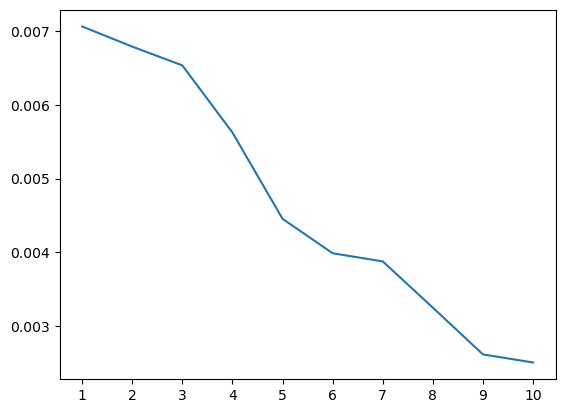

In [12]:
# Clustering K-Means
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters = i, init="k-means++", max_iter = 500, random_state=2)
  kmeans.fit(matrix_object.tf_idf_matrix)
  wcss.append(kmeans.inertia_)


print(wcss)

plt.plot(range(1, 11), wcss)
plt.xticks(range(1,11))
plt.show() # y axis = WCSS | x axis = k (# of clusters)



In [16]:
kmeans = KMeans(n_clusters = 8, init="k-means++", max_iter = 500, random_state=2)
predictions = kmeans.fit_predict(matrix_object.tf_idf_matrix)

# matrix_object.tf_idf_matrix["label"] = predictions

predictions

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([2, 2, 3, 6, 2, 2, 2, 2, 1, 2, 0, 2, 2, 5, 2, 2, 7, 2, 2, 2, 4, 2,
       2, 2])

In [ ]:
# main function
if __name__ == '__main__':

	logger.info("starting ...")

	#
	# PART 1
	#

	# does preprocessing on the files
	# returns a list of preprocessed file objects for each file
	logger.info("First: Do preprocessing on the files")
	processed_objects = do_preprocessing()

	# then give it the matrix class here
	logger.info("Next: Generating Document Term Matrix")
	matrix_object = generate_document_term_matrix()

	# then gather the list of topics per folder
	logger.info("Then: Consolidate and identify topics of each folder")


